In [1]:
from dataclasses import dataclass, field
from datetime import datetime as dt, timedelta as td
from time import sleep
import logging
from math import sqrt, pi

from matplotlib.pyplot import subplots
from scipy.stats import norm
import openai
from pandas import DataFrame, concat

from alexlib.db import Connection
from alexlib.envs import ConfigFile, chkenv
from alexlib.file import File, Directory
from alexlib.iters import link
from alexlib.ml.gpt import Messages

In [2]:
mean = 1
stdev = sqrt(pi) / 5
stdev

0.3544907701811032

In [3]:
db, hl_schema, hl_table = "headlines", "landing", "huffpost"
msg_schema, msg_table = "gpt", "messages"
exp_schema, exp_table = msg_schema, "experiments"
d = Directory(name="alexlib")
d.go_up(2)
config = ConfigFile(name=".env")
config.path
c = Connection.from_context("LOCAL")

In [4]:
openai.api_key = key = chkenv("OPENAI_API_KEY")
url = chkenv("OPENAI_API_ENDPOINT")
model = chkenv("OPENAI_MODEL")

In [5]:
"""
msgs = [
    {"role": "system", "content": "You are a human."},
    {"role": "user", "content": "Am I a human?"}
]
record = {
    "id": 0,
    "model": model,
    "endpoint": url,
    "date": dt.now(),
}
experiments = DataFrame.from_records([record])
experiments.head()
"""


'\nmsgs = [\n    {"role": "system", "content": "You are a human."},\n    {"role": "user", "content": "Am I a human?"}\n]\nrecord = {\n    "id": 0,\n    "model": model,\n    "endpoint": url,\n    "date": dt.now(),\n}\nexperiments = DataFrame.from_records([record])\nexperiments.head()\n'

In [6]:
@dataclass
class Message:
    role: str
    content: str

    @classmethod
    def as_system(cls, content: str):
        return cls("system", content)
    
    @classmethod
    def as_user(cls, content: str):
        return cls("user", content)

    @staticmethod
    def map_role_func(role: str):
        return {
            "system": Message.as_system,
            "user": Message.as_user,
        }[role]

    @classmethod
    def mk_input_seq(
        cls,
        
        msgs: list[str] = [
            {"system": "You are an insightful and helpful observer with a deep understanding of human emotion and motivations."},
            {"user": "What emotions would this headline cause in a typical person? 'Reporter Gets Adorable Surprise From Her Boyfriend While Live On TV'"}
        ]
    ):
        return [cls.map_role_func(msg) for msg in msgs]

sys_input_msg = {"role": "system", "content": }
usr_input_msg
input_msgs = [
    ,
    {"role": "user", "content": }
]

def get_exp_id(
        schema: str = exp_schema,
        table: str = exp_table,
        col: str = "id",
        isnew: bool = False,
    ):
    if isnew:
        return c.get_next_id(schema, table, col)
    else:
        return c.get_last_id(schema, table, col)

last_msg_id = lambda: c.get_last_id(msg_schema, msg_table, "message_id")

def mk_exp_record(
        schema: str = exp_schema,
        table: str = exp_table,
        isnew: bool = False,
        model: str = model,
        endpoint: str = url,
        date: dt = dt.now(),
): 
    return {
        "id": get_exp_id(schema, table, isnew=isnew),
        "model": model,
        "endpoint": endpoint,
        "date": date,
    }

def log_record(
        records: dict | list[dict],
        c: Connection,
        schema: str,
        table: str,
        if_exists: str = "append",
        index: bool = False,
) -> DataFrame:
    if isinstance(records, dict):
        records = [records]
    df = DataFrame.from_records(records)
    c.df_to_db(
        df, 
        schema,    
        table,
        if_exists=if_exists,
        index=index,
    )
def log_experiment(
        new_experiment: bool = False,
        conn: Connection = c,
        schema: str = exp_schema,
        table: str = exp_table,
):
    exp_record = mk_exp_record(new_experiment=new_experiment)
    log_record(exp_record, conn, schema, table)

def log_input_messages(
        msgs: list[dict] = input_msgs,
        conn: Connection = c,
        schema: str = msg_schema,
        table: str = msg_table,
):
    input_msgs = Messages.from_list(msgs, is_input=True)
    input_msgs = input_msgs.update_ids(last_msg_id())
    log_record(input_msgs.record_list, conn, schema, table)
    return input_msgs

def log_return_messages(
        msgs: list[dict],
        spiciness: list[float],
        conn: Connection = c,
        schema: str = msg_schema,
        table: str = msg_table,
):
    return_msgs = Messages.from_list(msgs, is_return=True)
    return_msgs = return_msgs.update_ids(last_msg_id())
    return_msgs = return_msgs.update_attr("spiciness", spiciness)
    log_record(return_msgs.record_list, conn, schema, table)
    return return_msgs

#log_experiment()
#log_input_messages()

Messages(lst=[Message(message_id=41, message_seq=0, role='system', content='You are an insightful and helpful observer with a deep understanding of human emotion and motivations.', spiciness=-1.0, is_input=True, is_return=False), Message(message_id=42, message_seq=1, role='user', content="What emotions would this headline cause in a typical person? 'Reporter Gets Adorable Surprise From Her Boyfriend While Live On TV'", spiciness=-1.0, is_input=True, is_return=False)], context='LOCAL', schema='gpt', table='messages')

(array([  26.,   23.,   24.,   19.,   21.,   37.,   31.,   38.,   31.,
          36.,   50.,   47.,   53.,   72.,   52.,   56.,   66.,   71.,
          80.,   93.,   99.,   90.,  115.,  122.,  104.,  109.,  138.,
         132.,  134.,  164.,  146.,  145.,  176.,  198.,  205.,  220.,
         227.,  225.,  242.,  280.,  302.,  269.,  322.,  316.,  330.,
         327.,  337.,  400.,  397.,  401.,  401.,  482.,  474.,  463.,
         461.,  488.,  556.,  543.,  607.,  581.,  621.,  622.,  663.,
         613.,  697.,  695.,  694.,  740.,  774.,  755.,  805.,  800.,
         852.,  830.,  898.,  947.,  904.,  904.,  933.,  961.,  940.,
         978.,  986.,  958., 1015., 1011., 1049., 1119., 1075., 1046.,
        1067., 1135., 1080., 1110., 1088., 1132., 1110., 1147., 1187.,
        1174., 1118., 1183., 1166., 1134., 1160., 1144., 1138., 1091.,
        1070., 1148., 1059., 1065., 1061., 1084., 1049., 1095., 1057.,
        1014.,  920.,  954., 1005.,  906.,  907.,  894.,  856.,  860.,
      

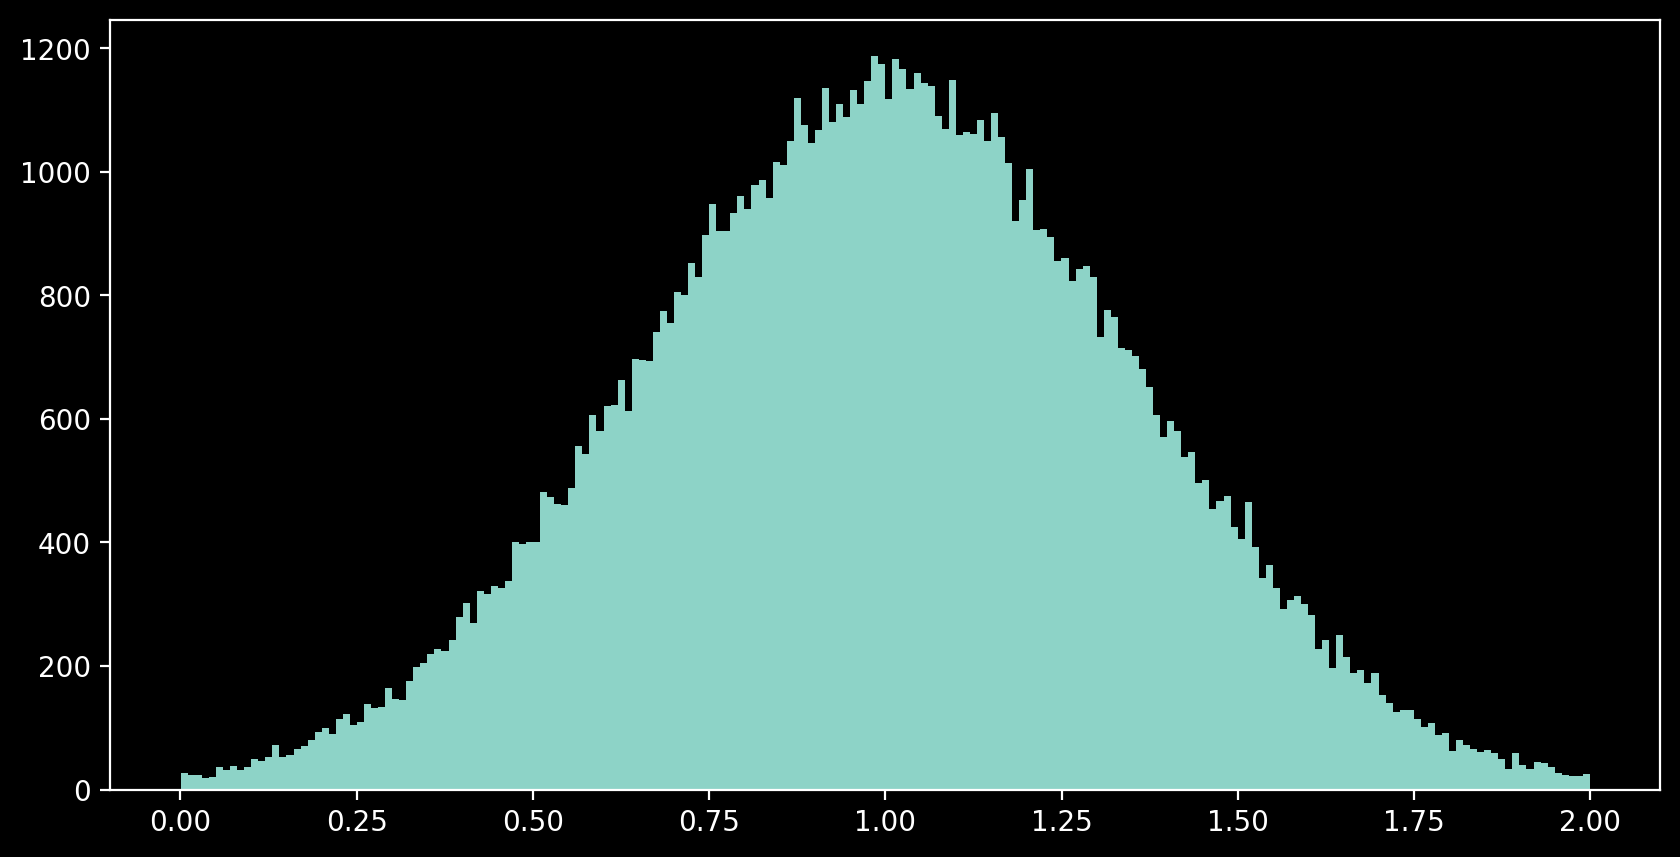

In [41]:
size = 100000
temp_rv = norm(mean, stdev)
one_val = lambda rv: rv.rvs(1)[0]
def bound_rv(
        value: float,
        lower: float = 0.01,
        upper: float = 1.99
        ,
        temp_rv: norm = temp_rv,
) -> list[float]:
    if (value < lower or value > upper):
        ret = bound_rv(one_val(temp_rv))
    else:
        ret = value
    return ret

def mk_bounded_rvs(
        rv: norm = temp_rv,
        size: int = size,
        lower: float = 0,
        upper: float = 2,
) -> list[float]:
    rvs = rv.rvs(size)
    return [bound_rv(r, lower, upper) for r in rvs]

mk_rand_val = lambda: bound_rv(one_val(temp_rv))
rvs = mk_bounded_rvs()
fig, ax = subplots(figsize=(10, 5), dpi=200)
ax.hist(rvs, bins=200)

In [ ]:
"""
"""
def mk_completion(
        model: str = model,
        input_msgs: list[dict] = input_msgs,
        temperature: float = mk_rand_val(),
):
    completion = openai.ChatCompletion.create(
        model=model,
        messages=input_msgs,
        temperature=temperature,
    )
    msg = completion.choices[0].message
    msg["spiciness"] = temperature
    return msg    


In [5]:
completions = []
doit = True
while doit is True:
    try:
        completion = mk_completion()
    except openai.error.RateLimitError:
        sleep(20)
        completion = mk_completion()
    print(completion)
    doit=False
    completions.append(completion)
completions

spiciness = 0.01, msg: Yes, you are a human.
spiciness = 0.06, msg: I cannot determine that as I do not have any information about you.
spiciness = 0.11, msg: Yes, you are a human.
spiciness = 0.16, msg: Yes, you are a human.
spiciness = 0.21, msg: Yes, you are a human.
spiciness = 0.26, msg: Yes, you are a human.
spiciness = 0.31, msg: Yes, you are a human.
spiciness = 0.36, msg: Yes, you are a human.
spiciness = 0.41, msg: I cannot determine that for certain as I am an AI and do not have access to personal information about you. However, assuming you are interacting with me as a human, it is likely that you are indeed a human.
spiciness = 0.46, msg: Yes, you are a human.
spiciness = 0.51, msg: I cannot determine that as I do not have information about you.
spiciness = 0.56, msg: I cannot confirm whether you are a human or not since I do not have any information about you.
spiciness = 0.61, msg: Based on the information you provided, I cannot determine whether you are a human or not.


KeyboardInterrupt: 

In [ ]:
df = Data

In [12]:
for completion in completions[:2]:
    print(completion)
df = DataFrame.from_records(completions)
df["spiciness"] = [i / 100 for i in range(1, 199, 5)][:-1]
df.head()

{
  "role": "assistant",
  "content": "Yes, you are a human."
}
{
  "role": "assistant",
  "content": "I cannot determine that as I do not have any information about you."
}


,role,content,spiciness
0,assistant,"Yes, you are a human.",0.01
1,assistant,I cannot determine that as I do not have any i...,0.06
2,assistant,"Yes, you are a human.",0.11
3,assistant,"Yes, you are a human.",0.16
4,assistant,"Yes, you are a human.",0.21


In [65]:
c = Connection.from_db("headlines")
c.get_info_schema(schema="landing")

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,headlines,landing,huffpost,index,1,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,headlines,landing,huffpost,link,2,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,headlines,landing,huffpost,headline,3,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,headlines,landing,huffpost,category,4,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,headlines,landing,huffpost,short_description,5,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,headlines,landing,huffpost,authors,6,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,headlines,landing,huffpost,date,7,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [66]:
c.create_schema("gpt")

In [67]:
experiments.to_sql("experiments", c.engine, schema="gpt", if_exists="replace", index=False)

1

In [59]:
# input messages
msgs_df = DataFrame.from_records(msgs)
msgs_df.loc[:, "spiciness"] = -1.
msgs_df.loc[:, "is_input"] = True
msgs_df.loc[:, "is_return"] = False
msgs_df.loc[:, "message_seq"] = list(range(len(msgs_df)))
msgs_df.head()

,role,content,spiciness,is_input,is_return,message_seq
0,system,You are a human.,-1.0,True,False,0
1,user,Am I a human?,-1.0,True,False,1


In [60]:
# return messages
return_msgs_df = DataFrame.from_records(completions)
return_msgs_df.loc[:, "spiciness"] = [i / 100 for i in range(1, 199, 5)][:-1]
return_msgs_df.loc[:, "is_input"] = False
return_msgs_df.loc[:, "is_return"] = True
return_msgs_df.loc[:, "message_seq"] = list(range(len(return_msgs_df)))
return_msgs_df.head()

,role,content,spiciness,is_input,is_return,message_seq
0,assistant,"Yes, you are a human.",0.01,False,True,0
1,assistant,I cannot determine that as I do not have any i...,0.06,False,True,1
2,assistant,"Yes, you are a human.",0.11,False,True,2
3,assistant,"Yes, you are a human.",0.16,False,True,3
4,assistant,"Yes, you are a human.",0.21,False,True,4


In [63]:
cols = ["message_seq", "role", "content", "spiciness", "is_input", "is_return"]
msgs_df = msgs_df.loc[:, cols]
msgs_df.reset_index(inplace=True, drop=True)
return_msgs_df = return_msgs_df.loc[:, cols]
return_msgs_df.reset_index(inplace=True, drop=True)
all_msgs_df = concat([msgs_df, return_msgs_df], ignore_index=False)
#all_msgs_df = concat([msgs_df.loc[:, cols], return_msgs_df.loc[:, cols]])
#all_msgs_df.reset_index()
all_msgs_df["message_id"] = list(range(len(all_msgs_df)))
all_msgs_df = all_msgs_df.loc[:, ["message_id"] + cols]
all_msgs_df.head()

,message_id,message_seq,role,content,spiciness,is_input,is_return
0,0,0,system,You are a human.,-1.00,True,False
1,1,1,user,Am I a human?,-1.00,True,False
0,2,0,assistant,"Yes, you are a human.",0.01,False,True
1,3,1,assistant,I cannot determine that as I do not have any i...,0.06,False,True
2,4,2,assistant,"Yes, you are a human.",0.11,False,True


In [68]:
all_msgs_df.to_sql("messages", c.engine, schema="gpt", if_exists="replace", index=False)

41

In [9]:
ids = {
    "experiment_id": 1,
}
tables = {
    "experiments": ids["experiment_id"],
    "completions": ids["experiment_id"],
    "input_messages": DataFrame.from_records(msgs),


}

[0.01,
 0.06,
 0.11,
 0.16,
 0.21,
 0.26,
 0.31,
 0.36,
 0.41,
 0.46,
 0.51,
 0.56,
 0.61,
 0.66,
 0.71,
 0.76,
 0.81,
 0.86,
 0.91,
 0.96,
 1.01,
 1.06,
 1.11,
 1.16,
 1.21,
 1.26,
 1.31,
 1.36,
 1.41,
 1.46,
 1.51,
 1.56,
 1.61,
 1.66,
 1.71,
 1.76,
 1.81,
 1.86,
 1.91,
 1.96]

n decoded = 209527
n errors = 1


In [70]:
Connection.mk_star_select
tbl = c.get_table(s, t)

In [ ]:
df.loc[:, "category"].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [ ]:
c.allschemas

['pg_catalog', 'information_schema']